In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
import numpy as np
import pandas as pd

# ---------------------------
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from scipy.stats import pearsonr

np.set_printoptions(suppress=True) # suppress scientific notation
np.random.seed(18937)

In [2]:
datasource = "datasets/HR_analytics.csv"
print(os.path.exists(datasource))

True


In [3]:
dataset = pd.read_csv(datasource).sample(frac = 1).reset_index(drop = True)
dataset.columns

Index(['Unnamed: 0', 'satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

In [6]:
del dataset["Unnamed: 0"]

In [8]:
dataset.head().transpose()

,0,1,2,3,4
satisfaction_level,0.4,0.9,0.67,0.09,0.72
last_evaluation,0.46,0.89,0.7,0.97,0.79
number_project,2,5,3,7,3
average_montly_hours,127,249,149,262,221
time_spend_company,3,3,3,4,3
Work_accident,0,1,0,0,0
left,1,0,0,1,0
promotion_last_5years,0,0,0,0,0
sales,hr,IT,support,technical,product_mng
salary,medium,low,low,low,high


## Preprocessing
Encode Salary and Sales columns

In [9]:
dataset["salary"].head()

0    medium
1       low
2       low
3       low
4      high
Name: salary, dtype: object

In [10]:
np.expand_dims(dataset["salary"], 1)

array([['medium'],
       ['low'],
       ['low'],
       ..., 
       ['low'],
       ['low'],
       ['low']], dtype=object)

In [11]:
encoder = LabelBinarizer()

In [12]:
salary_features = encoder.fit_transform(np.expand_dims(dataset["salary"], 1))

In [13]:
salary_features

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ..., 
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [14]:
for j, _class in enumerate(encoder.classes_):
    print(j, _class)    
    print('salary_{}'.format(_class.replace('\x20', '_'))) # this is building out the column names
    # whitespaces ( ) are replaces with underscores (_)
    print("===================")

0 high
salary_high
1 low
salary_low
2 medium
salary_medium


In [15]:
for j, _class in enumerate(encoder.classes_):
    dataset.loc[:, 'salary_{}'.format(_class.replace('\x20', '_'))] = salary_features[:, j]
    # JACKY: loop through each enumeration of the classes (low, medium, high)
    # and set the corresponding salary column to either 0 or 1.
    
dataset.head().transpose()

,0,1,2,3,4
satisfaction_level,0.4,0.9,0.67,0.09,0.72
last_evaluation,0.46,0.89,0.7,0.97,0.79
number_project,2,5,3,7,3
average_montly_hours,127,249,149,262,221
time_spend_company,3,3,3,4,3
Work_accident,0,1,0,0,0
left,1,0,0,1,0
promotion_last_5years,0,0,0,0,0
sales,hr,IT,support,technical,product_mng
salary,medium,low,low,low,high


...doing the same thing for Sales column

In [16]:
dataset["sales"].head()

0             hr
1             IT
2        support
3      technical
4    product_mng
Name: sales, dtype: object

In [17]:
encoder = LabelBinarizer()
sales_features = encoder.fit_transform(np.expand_dims(dataset["sales"], 1))

for j, _class in enumerate(encoder.classes_):
    dataset.loc[:, "sales_{}".format(_class.replace("\x20", "_"))] = sales_features[:, j]
    
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 23 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
salary_high              14999 non-null int32
salary_low               14999 non-null int32
salary_medium            14999 non-null int32
sales_IT                 14999 non-null int32
sales_RandD              14999 non-null int32
sales_accounting         14999 non-null int32
sales_hr                 14999 non-null int32
sales_management         14999 non-null int32
sales_marketing          14999 non-null int32
sales_produ

In [18]:
dataset.head().transpose()

,0,1,2,3,4
satisfaction_level,0.4,0.9,0.67,0.09,0.72
last_evaluation,0.46,0.89,0.7,0.97,0.79
number_project,2,5,3,7,3
average_montly_hours,127,249,149,262,221
time_spend_company,3,3,3,4,3
Work_accident,0,1,0,0,0
left,1,0,0,1,0
promotion_last_5years,0,0,0,0,0
sales,hr,IT,support,technical,product_mng
salary,medium,low,low,low,high


In [19]:
columns_to_keep = [0, 1, 2, 3, 4, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
df = dataset.copy() # copy for later
df = df.iloc[:, columns_to_keep]
X = np.array(dataset.iloc[:, columns_to_keep])
y = np.array(dataset["left"])

In [22]:
list(df.columns)

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'promotion_last_5years',
 'salary_high',
 'salary_low',
 'salary_medium',
 'sales_IT',
 'sales_RandD',
 'sales_accounting',
 'sales_hr',
 'sales_management',
 'sales_marketing',
 'sales_product_mng',
 'sales_sales',
 'sales_support',
 'sales_technical']

In [23]:
print(X.shape)

(14999, 20)


In [24]:
print(y.shape)

(14999,)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

## Feature Selection Methods
* Mutual Info
* Chi Square
* Forward Selection

In [26]:
def mutual_info_session(X_train, y_train, k, df):
    selector = SelectKBest(mutual_info_classif, k)
    selector.fit(X_train, y_train)    
    print("Selected feature indices:", selector.get_support(True))
    print("")
    print("Selected feature column names: \n", np.array(df.columns[selector.get_support(True)]))
    model = GaussianNB()
    model.fit(selector.transform(X_train), y_train)
    chi2_sklearn, pvalue_sklearn = chi2(selector.transform(X_train), y_train)
    print("")
    print("Selected Model Score: ", model.score(selector.transform(X_test), y_test))
    print("")
    print("p-values:", pvalue_sklearn)
    
print("MUTUAL INFO METHOD: \n")
for i in range(1, 16):
    print("k =", i)
    mutual_info_session(X_train, y_train, i, df)
    print("*******************************************")

MUTUAL INFO METHOD: 

k = 1
Selected feature indices: [0]

Selected feature column names: 
 ['satisfaction_level']

Selected Model Score:  0.756333333333

p-values: [ 0.]
*******************************************
k = 2
Selected feature indices: [0 2]

Selected feature column names: 
 ['satisfaction_level' 'number_project']

Selected Model Score:  0.778333333333

p-values: [ 0.          0.04831338]
*******************************************
k = 3
Selected feature indices: [0 2 3]

Selected feature column names: 
 ['satisfaction_level' 'number_project' 'average_montly_hours']

Selected Model Score:  0.770333333333

p-values: [ 0.          0.04831338  0.        ]
*******************************************
k = 4
Selected feature indices: [0 1 2 3]

Selected feature column names: 
 ['satisfaction_level' 'last_evaluation' 'number_project'
 'average_montly_hours']

Selected Model Score:  0.782333333333

p-values: [ 0.          0.86059374  0.04831338  0.        ]
**************************

In [27]:
def chi_feature_session(X_train, y_train, k, df):
    selector = SelectKBest(chi2, k)
    selector.fit(X_train, y_train)
    print("Selected feature indices:", selector.get_support(True))
    print("")
    print("Selected feature column names: \n", np.array(df.columns[selector.get_support(True)]))
    model = GaussianNB()
    model.fit(selector.transform(X_train), y_train)
    chi2_sklearn, pvalue_sklearn = chi2(selector.transform(X_train), y_train)
    print("")
    print("Selected Model Score: ", model.score(selector.transform(X_test), y_test))
    print("")
    print("p-values:", pvalue_sklearn)

print("CHI SQUARE METHOD: \n")
for i in range(1, 16):
    print("k =", i)
    chi_feature_session(X_train, y_train, i, df)
    print("*******************************************")

CHI SQUARE METHOD: 

k = 1
Selected feature indices: [3]

Selected feature column names: 
 ['average_montly_hours']

Selected Model Score:  0.759333333333

p-values: [ 0.]
*******************************************
k = 2
Selected feature indices: [3 5]

Selected feature column names: 
 ['average_montly_hours' 'Work_accident']

Selected Model Score:  0.776333333333

p-values: [ 0.  0.]
*******************************************
k = 3
Selected feature indices: [0 3 5]

Selected feature column names: 
 ['satisfaction_level' 'average_montly_hours' 'Work_accident']

Selected Model Score:  0.771

p-values: [ 0.  0.  0.]
*******************************************
k = 4
Selected feature indices: [0 3 5 7]

Selected feature column names: 
 ['satisfaction_level' 'average_montly_hours' 'Work_accident' 'salary_high']

Selected Model Score:  0.769

p-values: [ 0.  0.  0.  0.]
*******************************************
k = 5
Selected feature indices: [0 3 4 5 7]

Selected feature column names: 


In [28]:
class ForwardSelector(object):
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y, k):
        selected = np.zeros(X.shape[1]).astype(bool) # holds indicators of whether each feature is selected
        
        score = lambda X_features: clone(self.estimator).fit(X_features, y).score(X_features, y)
        # fit and score model based on some subset of features
        
        selected_indices = lambda: list(np.flatnonzero(selected))
        
        while np.sum(selected) < k: # keep looping until k features are selected
            rest_indices = list(np.flatnonzero(~selected)) # indices to unselected columns
            scores = list()
            
            for i in rest_indices:
                feature_subset = selected_indices() + [i]
                s = score(X[:, feature_subset])
                scores.append(s)
            idx_to_add = rest_indices[np.argmax(scores)]
            selected[idx_to_add] = True
        self.selected = selected.copy()
        return self
    
    def transform(self, X):
        return X[:, self.selected]
    
    def get_support(self, indices = False):
        return np.flatnonzero(self.selected) if indices else self.selected
    

def forward_selection_session(X_train, y_train, k, df):
    model = GaussianNB()
    selector = ForwardSelector(model)
    selector.fit(X_train, y_train, k)
    print("Selected feature indices:", selector.get_support(True))
    print("")
    print("Selected feature column names: \n", np.array(df.columns[selector.get_support(True)])) 
    model = GaussianNB()
    model.fit(selector.transform(X_train), y_train)
    chi2_sklearn, pvalue_sklearn = chi2(selector.transform(X_train), y_train)
    print("")
    print("Selected Model Score: ", model.score(selector.transform(X_test), y_test))
    print("")
    print("p-values:", pvalue_sklearn)

print("FORWARD SELECTION METHOD: \n")
for i in range(1, 16):
    print("k =", i)
    forward_selection_session(X_train, y_train, i, df)
    print("*******************************************")

FORWARD SELECTION METHOD: 

k = 1
Selected feature indices: [2]

Selected feature column names: 
 ['number_project']

Selected Model Score:  0.78

p-values: [ 0.04831338]
*******************************************
k = 2
Selected feature indices: [2 7]

Selected feature column names: 
 ['number_project' 'salary_high']

Selected Model Score:  0.848666666667

p-values: [ 0.04831338  0.        ]
*******************************************
k = 3
Selected feature indices: [1 2 7]

Selected feature column names: 
 ['last_evaluation' 'number_project' 'salary_high']

Selected Model Score:  0.864

p-values: [ 0.86059374  0.04831338  0.        ]
*******************************************
k = 4
Selected feature indices: [1 2 4 7]

Selected feature column names: 
 ['last_evaluation' 'number_project' 'time_spend_company' 'salary_high']

Selected Model Score:  0.867333333333

p-values: [ 0.86059374  0.04831338  0.          0.        ]
*******************************************
k = 5
Selected featu

## PCA and FA

In [29]:
# Add code below this comment
# ---------------------------
def Do_PCA(X, y, k):
    pca = PCA(n_components = k)
    pca.fit(X)
    print("PCA Variance Ratio:")
    print(pca.explained_variance_ratio_)
    print("")
    print("PCA Correlation Coefficient:")
    X_PCA = pca.transform(X)
    corr = np.array([pearsonr(X_PCA[:,i], y)[0] for i in range(X_PCA.shape[1])])
    print(corr)
    print("")
    X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size = 0.20)
    print("X Shape:", X.shape)
    print("X Train Shape:", X_train.shape)
    model = GaussianNB()
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print("")
    print("PCA Model Score:", score)
    return pca

In [30]:
def Do_FA(X, y, k):
    fa = FactorAnalysis(n_components = k)
    fa.fit(X)
    fa.explained_variance_ = np.flip(np.sort(np.sum(fa.components_**2, axis=1)), axis=0)
    total_variance = np.sum(fa.explained_variance_) + np.sum(fa.noise_variance_)
    fa.explained_variance_ratio_ = fa.explained_variance_ / total_variance
    print("FA Variance Ratio:")
    print(fa.explained_variance_ratio_)
    print("")
    X_FA = fa.transform(X)
    print("FA Correlation Coefficient:")
    corr = np.array([pearsonr(X_FA[:, i], y)[0] for i in range(X_FA.shape[1])])
    print(corr)
    print("")
    X_train, X_test, y_train, y_test = train_test_split(X_FA, y, test_size = 0.20)
    print("X Shape:", X.shape)
    print("X Train Shape:", X_train.shape)
    model = GaussianNB()
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)   
    print("")
    print("FA Model Score:", score)
    return fa

In [31]:
for i in range(1, 6):
    print("# of Components:", i)
    print("")
    Do_PCA(X, y, i)
    print("*******************************")

# of Components: 1

PCA Variance Ratio:
[ 0.99799953]

PCA Correlation Coefficient:
[ 0.07130068]

X Shape: (14999, 20)
X Train Shape: (11999, 1)

PCA Model Score: 0.76
*******************************
# of Components: 2

PCA Variance Ratio:
[ 0.99799953  0.00086934]

PCA Correlation Coefficient:
[ 0.07130068  0.1279722 ]

X Shape: (14999, 20)
X Train Shape: (11999, 2)

PCA Model Score: 0.785666666667
*******************************
# of Components: 3

PCA Variance Ratio:
[ 0.99799953  0.00086934  0.00047382]

PCA Correlation Coefficient:
[ 0.07130068  0.1279722   0.05292685]

X Shape: (14999, 20)
X Train Shape: (11999, 3)

PCA Model Score: 0.772333333333
*******************************
# of Components: 4

PCA Variance Ratio:
[ 0.99799953  0.00086934  0.00047382  0.00018284]

PCA Correlation Coefficient:
[ 0.07130068  0.1279722   0.05292685 -0.11594648]

X Shape: (14999, 20)
X Train Shape: (11999, 4)

PCA Model Score: 0.776333333333
*******************************
# of Components: 5

PC

In [32]:
for i in range(1, 6):
    print("# of Components:", i)
    print("")
    Do_FA(X, y, i)
    print("*******************************")

# of Components: 1

FA Variance Ratio:
[ 0.99759941]

FA Correlation Coefficient:
[ 0.07129426]

X Shape: (14999, 20)
X Train Shape: (11999, 1)

FA Model Score: 0.786333333333
*******************************
# of Components: 2

FA Variance Ratio:
[ 0.99758245  0.00017492]

FA Correlation Coefficient:
[ 0.07120925  0.13474323]

X Shape: (14999, 20)
X Train Shape: (11999, 2)

FA Model Score: 0.771666666667
*******************************
# of Components: 3

FA Variance Ratio:
[ 0.99753725  0.00019343  0.00009915]

FA Correlation Coefficient:
[-0.10678346 -0.1183807   0.07077728]

X Shape: (14999, 20)
X Train Shape: (11999, 3)

FA Model Score: 0.750333333333
*******************************
# of Components: 4

FA Variance Ratio:
[ 0.99753677  0.00032242  0.00019343  0.00009915]

FA Correlation Coefficient:
[-0.10678346 -0.1183807   0.07077605  0.04677649]

X Shape: (14999, 20)
X Train Shape: (11999, 4)

FA Model Score: 0.758
*******************************
# of Components: 5

FA Variance R

In [33]:
# Add code below this comment
# ---------------------------

def screePCA(k):
    pca_scree = Do_PCA(X, y, k) 
    x_ticks = np.arange(len(pca_scree.components_)) + 1
    plt.xticks(x_ticks)
    plt.plot(x_ticks, pca_scree.explained_variance_)
    plt.show()
    return pca_scree
    
def screeFA(k):
    fa_scree = Do_FA(X, y, k)
    x_ticks = np.arange(len(fa_scree.components_)) + 1
    plt.xticks(x_ticks)
    plt.plot(x_ticks, fa_scree.explained_variance_)
    plt.show()
    return fa_scree
    
def screeBoth(k):
    pca_k = screePCA(k)
    print("==================================================")
    fa_k = screeFA(k)
    print("==================================================")
    x_ticks = np.arange(len(pca_k.components_)) + 1
    plt.xticks(x_ticks)
    plt.plot(x_ticks, np.log(pca_k.explained_variance_), "b") # PCA
    plt.plot(x_ticks, np.log(fa_k.explained_variance_), "r") # FA
    plt.show()
    print("Blue line is PCA. Red line is FA.")

PCA Variance Ratio:
[ 0.99799953  0.00086934  0.00047382  0.00018284  0.00009487]

PCA Correlation Coefficient:
[ 0.07130068  0.1279722   0.05292686 -0.11594662 -0.00155014]

X Shape: (14999, 20)
X Train Shape: (11999, 5)

PCA Model Score: 0.784


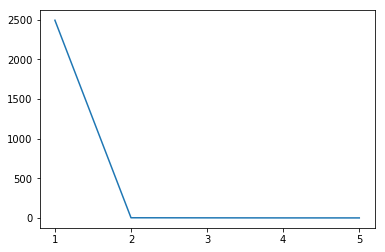

FA Variance Ratio:
[ 0.99753727  0.00032966  0.00019343  0.00009915  0.00008815]

FA Correlation Coefficient:
[-0.10678346 -0.1183807   0.07077574  0.00397993  0.04182286]

X Shape: (14999, 20)
X Train Shape: (11999, 5)

FA Model Score: 0.747


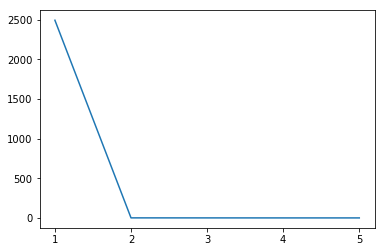

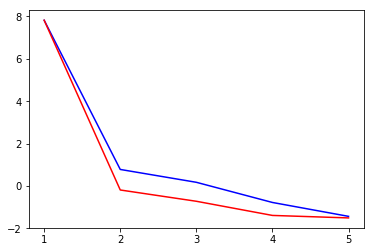

Blue line is PCA. Red line is FA.


In [34]:
screeBoth(5)